In [1]:
import os
from PIL import Image, ImageOps
import numpy as np
from math import ceil
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# Loading the Data

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

This code loads images from the men and women's clothing datasets from the fashion MNIST. The goal will be distinguishing between these.

To map the images to a uniform size, I use Pillow's resize function with cubic interpolation. Pillow will use cubis spline interpolation to build a map of the image, and then it will resample in the desired size. This means that images of any size can be resamples at any other size (although of course you wouldn't want to take this too far). I resample at 250x200 because this seems to strike a good balance of accuracy and speed.

In [3]:
n_imgs = 10000
size = 250, 200

men_files = ["data/men/" + s for s in os.listdir("data/men")[:n_imgs//2]]
women_files = ["data/women/" + s for s in os.listdir("data/women")[:ceil(n_imgs/2)]]

imgs = []
for file_name in men_files + women_files:
    with Image.open(file_name) as img:
        img = ImageOps.grayscale(img.resize(size, resample=Image.BICUBIC))
        imgs.append(np.array(img).flatten())

imgs = MinMaxScaler().fit_transform(np.vstack(imgs))

imgs.shape

(2512, 50000)

In [4]:
y = np.array([0]*len(men_files) + [1]*len(women_files))
x_train, x_test, y_train, y_test = train_test_split(imgs, y, test_size=0.2)

# Model Fitting

For classification of these images, I compare four models: logistic regression, logistic regression with PCA, logistic regression with LDA, and quadratic discriminant analysis (QDA) with PCA preprocessing.

One concern with a comparison like this is that if I just picked one set of hyperparameters for each, I might accidentally choose really good hyperparameters for one model and really bad ones for another. So, the comparison would really just be a comparison of my hyperparameter choices. To overcome this problem, I perform randomized hyperparameter search across a distribution of possible hyperparameters. Then, for each model, I only chose the best hyperparameters.

I have already split my data into training and test sets. For the randomized search, I use the sklearn RandomizedSearchCV on the training set. This uses 5-fold cross validation on the train set to discriminate between models. Then, I grade the best model from the search on the test set.

## Search Distributions

There are three hyperparameters that are used across the models.
- C the regularization parameter of the logistic regression
- ncomponents for the PCA
- regparam for the QDA


We need to define a probability distribution across these hyperparameters for each model. At each iteration of the randomized search, we will draw a set hyperparameters from this distribution to test.

For the logistic regression, C must be a positive float. The default value is 1, and smaller values specify more regularization. I decided to parametrize this with an exponential distribution with mean 1. This has the correct support, and it will prioritize sample smaller values.

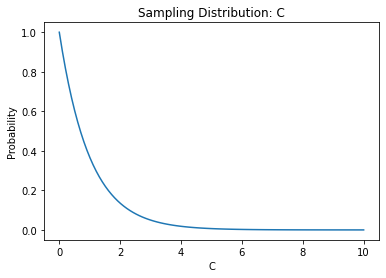

In [5]:
C = stats.expon(0, 1)

x = np.linspace(0, 10, 100)
plt.plot(x, C.pdf(x))
plt.title("Sampling Distribution: C")
plt.ylabel("Probability")
plt.xlabel("C")
plt.show()

For the PCA, n_components must be a positive integer upper-bounded by the min of the number of samples in each class and the number of features. I think the best is probably near the bottom of this range, but not close to zero, so I will use a binomial distribution with $n=min(n_samples_men, n_samples_women)$ and $p=0.2$.

/Users/leoware/Documents/Assignments/CS156 #4/venv/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


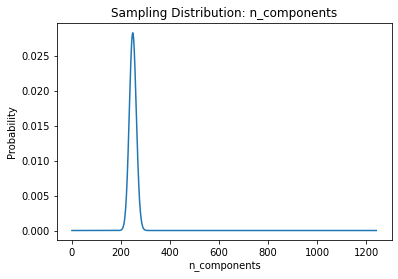

In [6]:
n = min(len(men_files), len(women_files))
# n = 50
n_components = stats.binom(n=n, p=0.2)

x = np.arange(0, n)
plt.plot(x, n_components.pmf(x))
plt.title("Sampling Distribution: n_components")
plt.ylabel("Probability")
plt.xlabel("n_components")
plt.show()

For the QDA, the algorithm estimates the covariance of the various features in each class and then uses this to decompose the problem. The final estimate of the covariance is a weighted sum of the MLE estimate and the identity matrix, which provides regularization. The $regparam$ controls the proportion of the final estimate that is contributed by the identity. This needs to be between 0 and 1, and I am guessing something closer to 0 will work better in general. So, I parametrize this with a beta distribution with $\alpha=1$ and $\beta=4$.

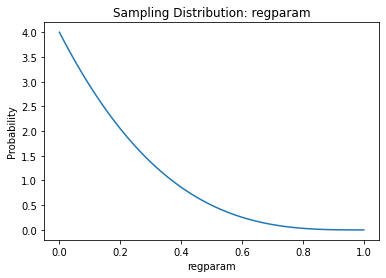

In [7]:
regparam = stats.beta(a=1, b=4)

x = np.linspace(0, 1, 100)
plt.plot(x, regparam.pdf(x))
plt.title("Sampling Distribution: regparam")
plt.ylabel("Probability")
plt.xlabel("regparam")
plt.show()

## Scoring the Models

In [8]:
model_basic = RandomizedSearchCV(LogisticRegression(), {"C": C})
model_basic.fit(x_train, y_train)
print(f"train score: {model_basic.score(x_train, y_train)}")
print(f"test score: {model_basic.score(x_test, y_test)}")

/Users/leoware/Documents/Assignments/CS156 #4/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/leoware/Documents/Assignments/CS156 #4/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

train score: 1.0
test score: 0.5825049701789264


In [9]:
model_pca = RandomizedSearchCV(
    make_pipeline(PCA(n_components=2), LogisticRegression()),
    {"pca__n_components": n_components, "logisticregression__C": C}
    )
model_pca.fit(x_train, y_train)
print(f"train score: {model_pca.score(x_train, y_train)}")
print(f"test score: {model_pca.score(x_test, y_test)}")

/Users/leoware/Documents/Assignments/CS156 #4/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/leoware/Documents/Assignments/CS156 #4/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

train score: 0.7332005973120955
test score: 0.6262425447316103


In [10]:
model_lda = RandomizedSearchCV(
    make_pipeline(LinearDiscriminantAnalysis(), LogisticRegression()),
    {"logisticregression__C": C},
)
model_lda.fit(x_train, y_train)
print(f"train score: {model_lda.score(x_train, y_train)}")
print(f"test score: {model_lda.score(x_test, y_test)}")

train score: 0.9273270283723245
test score: 0.5944333996023857


In [11]:
model_qda = RandomizedSearchCV(
    make_pipeline(PCA(), QuadraticDiscriminantAnalysis()),
    {"pca__n_components": n_components, "quadraticdiscriminantanalysis__reg_param": regparam},
)

model_qda.fit(x_train, y_train)
print(f"train score: {model_qda.score(x_train, y_train)}")
print(f"test score: {model_qda.score(x_test, y_test)}")

train score: 0.9462419113987058
test score: 0.6699801192842942
